# Book Text Summarization - Seq2Seq + Attention  
### AI Hub의 도서자료요약 데이터셋을 사용한 추상적 요약(abstractive summarization)

## 0. Import

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Okt

## 1. AI Hub .json file to .csv file

AI Hub의 도서자료 파일은 각각의 내용이 하나하나 json파일로 이루어져있습니다.  
이를 통합하여 데이터프레임을 만들고 파일로 저장하는 코드입니다.  
매우 시간이 오래 걸리니 변환한 csv파일을 사용하면 좋을 것 같습니다.

In [2]:
"""
train_cnt = 0
test_cnt = 0
train_data_dir = "../../dataset/BookSummarization/train/"
test_data_dir = "../../dataset/BookSummarization/test/"

for path in os.listdir(train_data_dir):
    if os.path.isfile(os.path.join(train_data_dir, path)):
        train_cnt += 1

for path in os.listdir(test_data_dir):
    if os.path.isfile(os.path.join(test_data_dir, path)):
        test_cnt += 1

print(f'학습 데이터 개수 = {train_cnt}, 테스트 데이터 개수 = {test_cnt}')
"""

'\ntrain_cnt = 0\ntest_cnt = 0\ntrain_data_dir = "../../dataset/BookSummarization/train/"\ntest_data_dir = "../../dataset/BookSummarization/test/"\n\nfor path in os.listdir(train_data_dir):\n    if os.path.isfile(os.path.join(train_data_dir, path)):\n        train_cnt += 1\n\nfor path in os.listdir(test_data_dir):\n    if os.path.isfile(os.path.join(test_data_dir, path)):\n        test_cnt += 1\n\nprint(f\'학습 데이터 개수 = {train_cnt}, 테스트 데이터 개수 = {test_cnt}\')\n'

In [3]:
"""
test_passage_data = []
test_summary_data = []

for i in range(len(os.listdir(test_data_dir))):
    target = pd.read_json(test_data_dir+os.listdir(test_data_dir)[i])
    test_passage_data.append(target['passage'][0])
    test_summary_data.append(target['summary'][0])
    
test_data = {
    'passage': test_passage_data, 'summary': test_summary_data
}

test_df = pd.DataFrame(test_data)

train_passage_data = []
train_summary_data = []

for i in range(len(os.listdir(train_data_dir))):
    target = pd.read_json(train_data_dir+os.listdir(train_data_dir)[i])
    train_passage_data.append(target['passage'][0])
    train_summary_data.append(target['summary'][0])
    
train_data = {
    'passage': train_passage_data, 'summary': train_summary_data
}

train_df = pd.DataFrame(train_data)

train_df.to_csv("../../dataset/BookSummarization/train_df/Book_train.csv")
test_df.to_csv("../../dataset/BookSummarization/test_df/Book_test.csv")
"""

'\ntest_passage_data = []\ntest_summary_data = []\n\nfor i in range(len(os.listdir(test_data_dir))):\n    target = pd.read_json(test_data_dir+os.listdir(test_data_dir)[i])\n    test_passage_data.append(target[\'passage\'][0])\n    test_summary_data.append(target[\'summary\'][0])\n    \ntest_data = {\n    \'passage\': test_passage_data, \'summary\': test_summary_data\n}\n\ntest_df = pd.DataFrame(test_data)\n\ntrain_passage_data = []\ntrain_summary_data = []\n\nfor i in range(len(os.listdir(train_data_dir))):\n    target = pd.read_json(train_data_dir+os.listdir(train_data_dir)[i])\n    train_passage_data.append(target[\'passage\'][0])\n    train_summary_data.append(target[\'summary\'][0])\n    \ntrain_data = {\n    \'passage\': train_passage_data, \'summary\': train_summary_data\n}\n\ntrain_df = pd.DataFrame(train_data)\n\ntrain_df.to_csv("../../dataset/BookSummarization/train_df/Book_train.csv")\ntest_df.to_csv("../../dataset/BookSummarization/test_df/Book_test.csv")\n'

## 2. Load data and preprocess  
train csv파일의 용량이 100MB를 넘어 GitHub에 업로드할 수 없습니다.  
GitHub의 구글 드라이브 링크를 참고해주세요.  
다운로드 후 아래 코드의 경로에 맞게 파일을 저장하면 코드가 정상 작동 됩니다.  

In [4]:
train = pd.read_csv('../../dataset/BookSummarization/train_df/Book_train.csv')
test = pd.read_csv('../../dataset/BookSummarization/test_df/Book_test.csv')

In [5]:
train.head()

,Unnamed: 0,passage,summary
0,0,"둘째, 제 16차 당 대회에서 공산당은 삼개대표 이론에 입각하여 생산력발전과 사회...",공산당은 16차 당대회에서 선진세력의 입당을 공식 허용했다. 이는 “당 건설 강화...
1,1,중앙기율검사위원회가 제출한 “기율보고”도 전과 크게 다른 점이 없었다. 청렴한 정...,"16차 당 대회에서는 청렴한 정치풍토 수립, 반부패투쟁 강력 추진, 법제건설 강화 ..."
2,2,"한편, 중국정치를 연구하는 학자에게 ‘제3세대’ 지도자에서 ‘제4세대’지도자로의 ...",사회주의 정치체제는 정치지도자를 선발하는 제도적 장치가 제대로 안 갖추어져 있기 ...
3,3,2) 국가정책의 변화\n 우리는 전국인대 대표들이 심의한 국무원의 “정부업무보고”...,"정부업무보고 등은 중국정부의 정책변화, 총리와 주요정책임자의 기자회견은 중국정부의..."
4,4,중국 정부의 2003년 예산도 이와 같은 정책방침에 맞추어 편성되었다. 우선 정부가...,"중국 정부의 핵심지출 항목순서는 농촌경제 발전지출, 사회보장 지출 등으로 이어진다...."


In [6]:
test.head()

,Unnamed: 0,passage,summary
0,0,이 장은 후진타오(호금도) 시대가 어떤 과정을 통해 등장했는가를 검토하는 것이다....,후진타오 시대는 제 3세대 지도자가 물러나며 제 4세대 지도자가 새로운 통치 집단...
1,1,한편 사영기업가의 입당허용이 단기간에 중국정치에 변화를 몰고 올 것 같지는 않다....,사영기업가 계층은 국가의 통제를 아직 벗어나지 못했다는 등의 이유로 단기간에 중국...
2,2,그런데 제 16차 당 대회에서는 민족주의를 강조하는 경향이 이전보다 더욱 두드러졌...,"공산당이 국민정당에 대해 민족정당이 된 것, 정치보고에 민족정신 등에 대한 강조가..."
3,3,2.3.2 제10기 전국인민대표대회 제 1차 회의(2003년)\n 2003년 3월 ...,2003년의 10기 전국인대 1차 회의는 주요 국가지도자에 대한 인선이 있었고 공...
4,4,1) 인선에 대한 총괄평가\n 제 10기 전국인대 제 1차 회의에서 선출(비준)된...,10기 전국인대 1차 회의는 완전하고 실질적인 권력이양이 이루어지지 않았다. 이에...


### 2.1 중복 값과 결측 값 제거

In [7]:
print(f'train shape => {train.shape}, test shape => {test.shape}')

train shape => (160002, 3), test shape => (19999, 3)


In [8]:
print('train passage 중복 제외 값의 수 :', train['passage'].nunique())
print('train summary 중복 제외 값의 수 :', train['summary'].nunique())
print('test passage 중복 제외 값의 수 :', test['passage'].nunique())
print('test summary 중복 제외 값의 수 :', test['summary'].nunique())

train passage 중복 제외 값의 수 : 159999
train summary 중복 제외 값의 수 : 158469
test passage 중복 제외 값의 수 : 19999
test summary 중복 제외 값의 수 : 19846


In [9]:
train.drop_duplicates(subset=['passage'], inplace=True)
train.drop_duplicates(subset=['summary'], inplace=True)
test.drop_duplicates(subset=['passage'], inplace=True)
test.drop_duplicates(subset=['summary'], inplace=True)

In [10]:
print(f'train shape => {train.shape}, test shape => {test.shape}')

train shape => (158466, 3), test shape => (19846, 3)


In [11]:
train.isnull().sum()

Unnamed: 0    0
passage       0
summary       0
dtype: int64

In [12]:
test.isnull().sum()

Unnamed: 0    0
passage       0
summary       0
dtype: int64

In [13]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

### 2.2 불용어 제거

전체 데이터를 사용할 경우 양이 많아 시간이 너무 많이 소요되었습니다.  
데이터의 일부만 사용해 앞으로의 과정을 진행하도록 하겠습니다.  

In [14]:
target_train = train.iloc[0:500]
target_test = test.iloc[0:100]

In [15]:
from timeit import default_timer as timer
from datetime import timedelta

In [16]:
def stopword(train, test):
    
    start = timer()
    print("timer start!")
    
    tokenizer = Okt()
    
    train_passage_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(passage_)] for passage_ in train['passage']]
    test_passage_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(passage_)] for passage_ in test['passage']]
    train_summary_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(summary_)] for summary_ in train['summary']]
    test_summary_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(summary_)] for summary_ in test['summary']]
    
    exclusion_tags_train = [
    'Josa', 'PreEomi', 'Eomi', 'Suffix', 'Punctuation', 'KoreanParticle',
    'Hashtag', 'ScreenName', 'Email', 'URL'
    ]
    
    exclusion_tags_test = [
        'Punctuation', 'KoreanParticle', 'Hashtag', 'ScreenName', 'Email', 'URL'
    ]
    
    f = lambda x: x in exclusion_tags_train
    k = lambda x: x in exclusion_tags_test
    
    train_passage = []
    test_passage = []
    train_summary = []
    test_summary = []
    
    for i in range(len(train_passage_tokenized)):
        temp = []
        for j in range(len(train_passage_tokenized[i])):
            if f(train_passage_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_passage_tokenized[i][j].split('/')[0])
        train_passage.append(temp)
        
    for i in range(len(test_passage_tokenized)):
        temp = []
        for j in range(len(test_passage_tokenized[i])):
            if f(test_passage_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_passage_tokenized[i][j].split('/')[0])
        test_passage.append(temp)
                
    for i in range(len(train_summary_tokenized)):
        temp = []
        for j in range(len(train_summary_tokenized[i])):
            if k(train_summary_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_summary_tokenized[i][j].split('/')[0])
        train_summary.append(temp)
            
    for i in range(len(test_summary_tokenized)):
        temp = []
        for j in range(len(test_summary_tokenized[i])):
            if k(test_summary_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_summary_tokenized[i][j].split('/')[0])
        test_summary.append(temp)

    end = timer()
    print("timer end!")
    
    print("Time elapsed: ", end - start)  # seconds
    print("Time elapsed: ", timedelta(seconds=end-start))
    
    return train_passage, test_passage, train_summary, test_summary

In [17]:
train_passage, test_passage, train_summary, test_summary = stopword(target_train, target_test)

timer start!
timer end!
Time elapsed:  15.020454
Time elapsed:  0:00:15.020454


In [18]:
target_train['passage'] = train_passage
target_test['passage'] = test_passage
target_train['summary'] = train_summary
target_test['summary'] = test_summary

C:\Users\Home\AppData\Local\Temp/ipykernel_17212/3144626477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_train['passage'] = train_passage
C:\Users\Home\AppData\Local\Temp/ipykernel_17212/3144626477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_test['passage'] = test_passage
C:\Users\Home\AppData\Local\Temp/ipykernel_17212/3144626477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [19]:
target_train.replace('', np.nan, inplace=True)
print(target_train.isnull().sum())

target_test.replace('', np.nan, inplace=True)
print(target_test.isnull().sum())

index         0
Unnamed: 0    0
passage       0
summary       0
dtype: int64
index         0
Unnamed: 0    0
passage       0
summary       0
dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [20]:
print(f'train shape => {target_train.shape}, test shape => {target_test.shape}')

train shape => (500, 4), test shape => (100, 4)


In [21]:
all_passage = list(train_passage)+list(test_passage)
all_summary = list(train_summary)+list(test_summary)

In [22]:
passage_len = [len(data) for data in all_passage]
summary_len = [len(data) for data in all_summary]

In [23]:
print('텍스트의 최소 길이 : {}'.format(np.min(passage_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(passage_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(passage_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 82
텍스트의 최대 길이 : 315
텍스트의 평균 길이 : 172.29333333333332
요약의 최소 길이 : 20
요약의 최대 길이 : 129
요약의 평균 길이 : 62.248333333333335


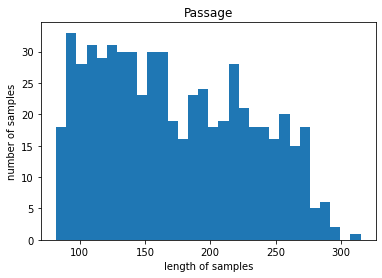

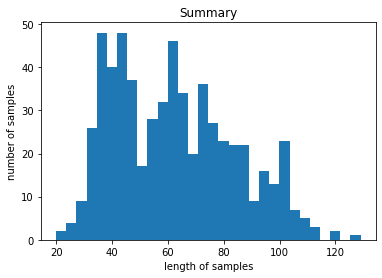

In [24]:
plt.title('Passage')
plt.hist(passage_len, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
passage_max_len = 300
summary_max_len = 120

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [27]:
below_threshold_len(passage_max_len, all_passage)
below_threshold_len(summary_max_len, all_summary)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 0.9983333333333333
전체 샘플 중 길이가 120 이하인 샘플의 비율: 0.9966666666666667


In [28]:
target_train = target_train[target_train['passage'].apply(lambda x: len(x) <= passage_max_len)]
target_train = target_train[target_train['summary'].apply(lambda x: len(x) <= summary_max_len)]
print('target_train 전체 샘플수 :',(len(target_train)))

target_test = target_test[target_test['passage'].apply(lambda x: len(x) <= passage_max_len)]
target_test = target_test[target_test['summary'].apply(lambda x: len(x) <= summary_max_len)]
print('target_test 전체 샘플수 :',(len(target_test)))

target_train 전체 샘플수 : 497
target_test 전체 샘플수 : 100


In [29]:
target_train['decoder_input'] = target_train['summary'].apply(lambda x : ['<SOS>'] + x)
target_train['decoder_target'] = target_train['summary'].apply(lambda x : x + ['<EOS>'])

target_test['decoder_input'] = target_test['summary'].apply(lambda x : ['<SOS>'] + x)
target_test['decoder_target'] = target_test['summary'].apply(lambda x : x + ['<EOS>'])

In [30]:
target_train.head()

,index,Unnamed: 0,passage,summary,decoder_input,decoder_target
0,0,0,"[둘째, 제, 16, 차, 당, 대회, 공산당, 삼, 개, 대표, 이론, 입, 각하...","[공산당, 은, 16, 차, 당, 대회, 에서, 선진, 세력, 의, 입당, 을, 공...","[<SOS>, 공산당, 은, 16, 차, 당, 대회, 에서, 선진, 세력, 의, 입...","[공산당, 은, 16, 차, 당, 대회, 에서, 선진, 세력, 의, 입당, 을, 공..."
1,1,1,"[중앙, 기, 율, 검사, 위원회, 제출, “, 기, 율, 보고, ”, 도, 전과,...","[16, 차, 당, 대회, 에서는, 청렴, 한, 정치, 풍토, 수립, 반, 부패, ...","[<SOS>, 16, 차, 당, 대회, 에서는, 청렴, 한, 정치, 풍토, 수립, ...","[16, 차, 당, 대회, 에서는, 청렴, 한, 정치, 풍토, 수립, 반, 부패, ..."
2,2,2,"[한편, 중국, 정치, 연구, 하는, 학자, ‘, 제, 3, 세대, 지도자, ‘, ...","[사회주의, 정치체제, 는, 정치, 지도자, 를, 선발, 하는, 제도, 적, 장치,...","[<SOS>, 사회주의, 정치체제, 는, 정치, 지도자, 를, 선발, 하는, 제도,...","[사회주의, 정치체제, 는, 정치, 지도자, 를, 선발, 하는, 제도, 적, 장치,..."
3,3,3,"[2, 국가, 정책, 변화, \n , 우리, 전국, 인대, 대표, 심의, 국무원, ...","[정부, 업무, 보고, 등, 은, 중국, 정부, 의, 정책, 변화, 총리와, 주요,...","[<SOS>, 정부, 업무, 보고, 등, 은, 중국, 정부, 의, 정책, 변화, 총...","[정부, 업무, 보고, 등, 은, 중국, 정부, 의, 정책, 변화, 총리와, 주요,..."
4,4,4,"[중국, 정부, 2003년, 예산, 이, 같은, 정책, 방침, 맞추어, 편성, 되었...","[중국, 정부, 의, 핵심, 지출, 항, 목순, 서는, 농촌, 경제, 발전, 지출,...","[<SOS>, 중국, 정부, 의, 핵심, 지출, 항, 목순, 서는, 농촌, 경제, ...","[중국, 정부, 의, 핵심, 지출, 항, 목순, 서는, 농촌, 경제, 발전, 지출,..."


In [31]:
encoder_input_train = np.array(target_train['passage'])
decoder_input_train = np.array(target_train['decoder_input'])
decoder_target_train = np.array(target_train['decoder_target'])

encoder_input_test = np.array(target_test['passage'])
decoder_input_test = np.array(target_test['decoder_input'])
decoder_target_test = np.array(target_test['decoder_target'])

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 497
훈련 레이블의 개수 : 497
테스트 데이터의 개수 : 100
테스트 레이블의 개수 : 100


In [32]:
def vocab(target, vocab_size):
    words = np.concatenate(target).tolist()
    counter = Counter(words)
    counter = counter.most_common(vocab_size-3)
    print(f'counter length : {len(counter)}')
    
    vocab = ['<PAD>', '<SOS>', '<EOS>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    print(f'word_to_index length : {len(word_to_index)}')
    
    return word_to_index, vocab_size

In [33]:
def encoder_wordlist_to_indexlist(wordlist):
        return [encoder_word_to_index[word] if word in encoder_word_to_index else encoder_word_to_index['<PAD>'] for word in wordlist]

In [34]:
def decoder_wordlist_to_indexlist(wordlist):
        return [decoder_word_to_index[word] if word in decoder_word_to_index else decoder_word_to_index['<PAD>'] for word in wordlist]

In [35]:
encoder_word_to_index, src_vocab = vocab(encoder_input_train, 10000)

counter length : 9997
word_to_index length : 10000


In [36]:
encoder_input_train = list(map(encoder_wordlist_to_indexlist, encoder_input_train))
encoder_input_test = list(map(encoder_wordlist_to_indexlist, encoder_input_test))

In [37]:
decoder_word_to_index, tar_vocab = vocab(decoder_input_train, 4000)

counter length : 3997
word_to_index length : 3999


In [38]:
encoder_index_to_word = {index:word for word, index in encoder_word_to_index.items()}
decoder_index_to_word = {index:word for word, index in decoder_word_to_index.items()}

In [39]:
decoder_input_train = list(map(decoder_wordlist_to_indexlist, decoder_input_train))
decoder_target_train = list(map(decoder_wordlist_to_indexlist, decoder_target_train))
decoder_input_test = list(map(decoder_wordlist_to_indexlist, decoder_input_test))
decoder_target_test = list(map(decoder_wordlist_to_indexlist, decoder_target_test))

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, padding='post', value=encoder_word_to_index["<PAD>"], maxlen=passage_max_len)
encoder_input_test = pad_sequences(encoder_input_test, padding='post', value=encoder_word_to_index["<PAD>"], maxlen=passage_max_len)
decoder_input_train = pad_sequences(decoder_input_train, padding='post', value=decoder_word_to_index["<PAD>"], maxlen=summary_max_len)
decoder_target_train = pad_sequences(decoder_target_train, padding='post', value=decoder_word_to_index["<PAD>"], maxlen=summary_max_len)
decoder_input_test = pad_sequences(decoder_input_test, padding='post', value=decoder_word_to_index["<PAD>"], maxlen=summary_max_len)
decoder_target_test = pad_sequences(decoder_target_test, padding='post', value=decoder_word_to_index["<PAD>"], maxlen=summary_max_len)

In [41]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(passage_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [43]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [45]:
from tensorflow.keras.layers import Attention

# 어텐션 층(어텐션 함수)
attention_layer = Attention()

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attention_out = attention_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 128)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 300, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 64, callbacks=[es], epochs = 1)

8/8 [==============================] - 66s 7s/step - loss: 5.6736 - val_loss: 3.7645


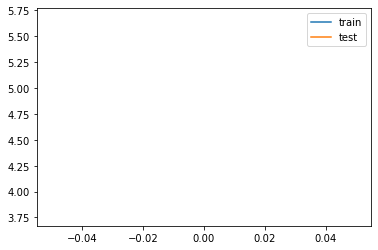

In [48]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
#어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(passage_max_len, hidden_size))
attn_out_inf = attention_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = decoder_word_to_index['<SOS>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = decoder_index_to_word[sampled_token_index]

        if(sampled_token!='<EOS>'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == '<EOS>' or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + encoder_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=decoder_word_to_index['<SOS>']) and i!=decoder_word_to_index['<EOS>']):
            sentence = sentence + decoder_index_to_word[i] + ' '
    return sentence

In [53]:
for i in range(10, 13):
    print("원문 : ",seq2text(encoder_input_test[i]),"\n")
    print("실제 요약문 :",seq2summary(decoder_input_test[i]),"\n")
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, passage_max_len)))
    print("\n")

원문 :  한편 신임 원자바오 총리 말 정치 개혁 즉 민주 정책 결정 기 제 수립 법 근거 행정 민주 감독 인민 대표 회의 감독 민주 감독 군중 및 여론 감독 강화 등 당분간 중국 급격한 정치 개혁 이루어질 가능성 않 음 보여주었다 
  “ ” 의 인터넷 인 은 제 10 기 전국 인대 제 1 차 회의 개최 되기 직전 대한 국민 관심 고조 시키기 위해 이번 회의 논의 될 20 가지 주제 중 가장 관심 있는 주제 선택 설문조사 실시 했다 이 따르면 국민 가장 관심 갖는 주제 부패 ) 였고 그 뒤 사법 개혁 개선 공산당 통치 방식 개선 사회보장 제도 수립 ) 순 이었다 이 중 사법 제도 개혁 법원 및 검찰 심각한 부패 문제 관련 있는 것 공산당 통치 방식 개선 작 부패 문제 관련 있는 내용 이렇게 보면 국민 부패 문제 사회보장 제도 수립 문제 가장 해결 해야 할 정부 과제 생각 있다  

실제 요약문 : 가 말 한 정치 개혁 은 중국 에서 이루어질 가능성 이 은 에 대한 국민 의 관심 을 회의 에서 논의 될 20 가지 주제 에 대한 를 실시 했고 국민 들 은 부패 사법 개혁 도 개선 등 의 순 으로 관심 을 가졌다  

예측 요약문 :  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

KeyboardInterrupt: 